In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd
import seaborn as sns
data = np.random.normal(loc = 10, scale = 2, size = 1000)

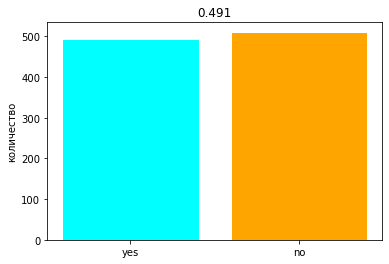

In [2]:
"""
Потребность во множественный сравнениях возникает когда мы хотим сравнить число групп
большее 2-х.
Если мы начнём попарно сравнивать между собой каждую выборку с каждой (даже
если они сделаны из одной генеральной совокупности),
то велика вероятность того, что мы получим статистически значимые различия
хотя бы 2-х из этих выборок.
"""
# Количество сравнений = n * (n-1) / 2, где n - число групп.

def my_ttest(selection1, selection2, selections_size):
    
    mu1 = np.mean(selection1)
    mu2 = np.mean(selection2)
    sd1 = SKO(selection1)
    sd2 = SKO(selection2)
    se = (sd1 ** 2 / selections_size + sd2 ** 2 / selections_size) ** 0.5
    T = (mu1 - mu2) / se
    df = selections_size * 2 - 2
    return ss.t.sf(abs(T), df=df) * 2


def SKO(ar):
    
    summary = 0
    avg = np.mean(ar)
    for i in ar:
        summary += ((avg - i) ** 2)
    return (summary / (len(ar)-1)) ** 0.5


def generate_selections(
    data,
    selections_amount,
    selections_size
):
    # Генерируем выборки
    
    selections = []
    selections.append(np.random
                      .choice(data, selections_size, replace=False))
    for i in range(selections_amount-1):
        selections.append(np.random
                  .choice(data, selections_size, replace=False))
    return selections
 
    
def comparisons_amount(selections_amount):
    
    # Количество сравнений = n * (n-1) / 2, где n - число групп.
    return selections_amount * (selections_amount - 1) / 2


def plot(result, trys):
    
    barlist = plt.bar(["yes", "no"], [result[0], result[1]], color='orange')
    barlist[0].set_color('cyan')
    plt.title(round(result[0] / trys, 3))
    plt.ylabel('количество')
    plt.show()
    

def multiple_comparisons(
    data,
    selections_amount,
    selections_size,
    alpha = 0.05,
    trys = 1000
):

    comparisons = comparisons_amount(selections_amount)
    result = {}
    result[1] = 0
    result[0] = 0
    for _ in range(1000):
        selections = generate_selections(data,
                                 selections_amount,
                                 selections_size)
        flag = True
        for i in range(len(selections)):
            for j in range(len(selections)):
                if i == j:
                    continue
                p_value = my_ttest(selections[i], selections[j], selections_size)
                if p_value < alpha:
                    flag = False
                    break
            if not flag:
                break
        if flag:
            result[1] += 1
        else:
            result[0] += 1
    plot(result, trys)

            
            
    

    

multiple_comparisons(data, 8, 30)
    



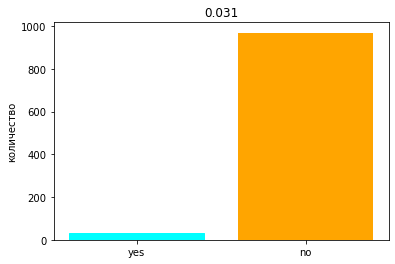

In [3]:
"""
Поэтому нам предлагается сделать поправку Бенферони (очень консервативна,
рекомендуется использовать другие варианты поправок).
Т. к. вероятность ошибки первого рода возрастает пропорциональ количеству групп 
(или количеству проверяемых в эксперименте гипотез), то и показалель alpha (p-value)
надо поделить на количество попарных сравнений.
"""
# Количество сравнений = n * (n-1) / 2, где n - число групп.
multiple_comparisons(data, 8, 30, 0.05 / comparisons_amount(8))


In [9]:
"""
Вместо поправки Бенферони можно использовать критерий Тьюки (Tukey HSD).
Предлагается расчитать доверительный интервал для разности средних 2-х выборок
(Xa - Xb), и если доверительный интервал не включает в себя 0, то можно отклонить
нулевую гипотезу о равенстве средних.
"""
a = np.random.choice(data, 2, replace=False)
b = np.random.choice(data, 2, replace=False)
c = np.random.choice(data, 2, replace=False)


abc = np.concatenate((a, b, c))
df = pd.DataFrame({'score': abc,
 'group': np.repeat(['a', 'b', 'c'], repeats= len(abc) / 3)})

tukey = pairwise_tukeyhsd(endog=df['score'],
                          groups=df['group'],
                          alpha= 0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     a      b  -3.2721 0.2839 -10.4788 3.9346  False
     a      c  -0.6946    0.9  -7.9013 6.5121  False
     b      c   2.5775 0.4093  -4.6292 9.7842  False
----------------------------------------------------


<AxesSubplot:xlabel='group', ylabel='score'>

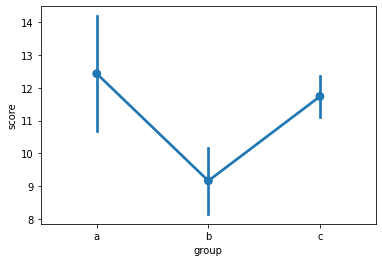

In [17]:
sns.pointplot(data=df, x = "group", y = "score")